In [2]:
import sympy as sym 
import numpy as np
from typing import Tuple

In [3]:
#let us use cutlass notation and _ at the end of symbols 
x, y = sym.symbols('x, y')


In [4]:
f_sym = x**2 + sym.sin(y)

In [5]:
f_realized = sym.lambdify([x,y], f_sym, 'numpy')

In [6]:
X = np.random.randn(10)
Y = np.random.randn(1) 
g = f_realized(X,Y)
g

array([1.52336844, 0.7131885 , 2.10522947, 2.70898758, 0.62966293,
       3.97208784, 0.67477482, 1.4807509 , 0.90731356, 1.28689889])

In [7]:
X 

array([ 0.94642801, -0.29248256, -1.21556037,  1.44268677,  0.04494972,
        1.82878249, -0.2170999 ,  0.9236387 ,  0.5288394 , -0.81194608])

In [8]:
Y

array([0.67852119])

In [9]:
class Layout: 
  def __init__ (self, shape: Tuple[sym.Symbol,...], stride: Tuple[sym.Symbol,...], 
                kind: str, input_symbol: sym.Symbol):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape_stride = [sym.Integer(1)]*self.m
    self.shape = shape 
    self.stride = stride
    

    for i in reversed(range(self.m-1)): 
      self.shape_stride[i] = self.shape[i]*self.shape_stride[i+1]
      
    self.shape_stride = tuple(self.shape_stride)  
    self.I = input_symbol

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.shape_stride[i]) % self.shape[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.stride[i]*self.fan_out_sym[i]
      
    self.layout = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    
    
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr



In [10]:
shape = (sym.symbols('M'), sym.symbols('N')) 
stride = (sym.symbols('P'), sym.symbols('Q'))
kind = "mem" 
input_symbol = sym.symbols('x')

L = Layout(shape, stride, kind, input_symbol)


In [11]:
L.shape_stride

(M, 1)

In [12]:
L.fan_out

(Mod(floor(x/M), M), Mod(floor(x), N))

In [13]:
L.fan_in

P*y_0 + Q*y_1

In [14]:
L.layout

P*(Mod(floor(x/M), M)) + Q*(Mod(floor(x), N))

In [15]:
class Layout: 
  def __init__ (self, shape: Tuple[int,...], stride: Tuple[int,...], 
                kind: str):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape = tuple([sym.Integer(shape[i]) for i in range(self.m)])
    self.stride = tuple([sym.Integer(stride[i]) for i in range(self.m)])
    self.S = tuple([sym.Symbol(f"S_{str(i)}") for i in range(self.m)])
    self.S_S = [sym.Integer(1)]*self.m
    self.D = tuple([sym.Symbol(f"D_{str(i)}") for i in range(self.m)])
    self.I = sym.Symbol("x")
    self.N_elems = 1 
    for i in range(self.m): 
      self.N_elems *= shape[i]
      
    
    for i in reversed(range(self.m-1)): 
      self.S_S[i] = self.S[i+1]*self.S_S[i]
      
    self.S_S = tuple(self.S_S)  
    

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.S_S[i]) % self.S[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.D[i]*self.fan_out_sym[i]
      
    self.layout_sym = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    self.layout = self._substitute(self.layout_sym, self.shape, self.S)
    self.layout = self._substitute(self.layout, self.stride, self.D)
    self.realized_layout = "un_realized"
    
    
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    one_d_domain = np.arange(self.N_elems) 
    layout_lambda = sym.lambdify([self.I], self.layout, "numpy")
    self.realized_layout = layout_lambda(one_d_domain).astype(int)
    
   



In [16]:
shape = (16,4,2)
stride = (17,9,1)
L = Layout(shape, stride, "mem")

In [17]:
L.S

(S_0, S_1, S_2)

In [23]:
L.fan_out
L.fan_in
L.layout_sym
L.layout

17*(Mod(floor(x/4), 16)) + 9*(Mod(floor(x/2), 4)) + Mod(floor(x), 2)

In [24]:
L.realized_layout

'un_realized'

In [25]:
L.realize()

In [26]:
L.realized_layout

array([  0,   1,   9,  10,  35,  36,  44,  45,  34,  35,  43,  44,  69,
        70,  78,  79,  68,  69,  77,  78, 103, 104, 112, 113, 102, 103,
       111, 112, 137, 138, 146, 147, 136, 137, 145, 146, 171, 172, 180,
       181, 170, 171, 179, 180, 205, 206, 214, 215, 204, 205, 213, 214,
       239, 240, 248, 249, 238, 239, 247, 248, 273, 274, 282, 283,   0,
         1,   9,  10,  35,  36,  44,  45,  34,  35,  43,  44,  69,  70,
        78,  79,  68,  69,  77,  78, 103, 104, 112, 113, 102, 103, 111,
       112, 137, 138, 146, 147, 136, 137, 145, 146, 171, 172, 180, 181,
       170, 171, 179, 180, 205, 206, 214, 215, 204, 205, 213, 214, 239,
       240, 248, 249, 238, 239, 247, 248, 273, 274, 282, 283])

In [28]:

class Swizzle:
    
  BitAnd = sym.Function('BitAnd')
  BitOr  = sym.Function('BitOr')
  BitXor = sym.Function('BitXor')
  RShift = sym.Function('RShift')
  LShift = sym.Function('LShift')
  BitNot = sym.Function('BitNot')
  Max = sym.Max
  Min = sym.Min

  def __init__(self, m_base: int, b_bits: int, s_shift: int, N_elems: int):
      
    assert m_base >= 0 
    assert b_bits >= 0 
    assert abs(s_shift) >= b_bits 
    self.N_elems = N_elems
    
    self.m_base = sym.Integer(m_base)
    self.b_bits = sym.Integer(b_bits)
    self.s_shift = sym.Integer(s_shift)
    
    self.b = sym.Symbol('b', integer=True) 
    self.m = sym.Symbol('m', integer=True)
    self.s = sym.Symbol('s', integer=True)
    self.x = sym.Symbol('x', integer=True)

    LShift, BitAnd, BitOr = Swizzle.LShift, Swizzle.BitAnd, Swizzle.BitOr
    BitXor, RShift = Swizzle.BitXor, Swizzle.RShift
    Max, Min = Swizzle.Max, Swizzle.Min

    one = sym.Integer(1) 
    zero = sym.Integer(0)

    base_mask = (LShift(one, self.b)) - 1
    src_shift = self.m + Max(zero, self.s)
    dst_shift = self.m - Min(zero, self.s)
    
    src_mask = LShift(base_mask, src_shift) 
    dst_mask = LShift(base_mask, dst_shift)
    
    bits_to_move = BitAnd(self.x, src_mask)
    
    self.swizzle_mask = BitOr(src_mask, dst_mask)
    
    expr_pos_s = BitXor(self.x, RShift(bits_to_move, self.s))
    expr_neg_s = BitXor(self.x, LShift(bits_to_move, -self.s))

    self.swizzle_map_sym = sym.Piecewise(
        (expr_pos_s, self.s >= 0),
        (expr_neg_s, True)
    )
    self.swizzle_map = self._substitute(self.swizzle_map_sym, (self.m_base, self.b_bits, self.s_shift), (self.m, self.b, self.s))
    self.realized_swizzle_map = "un_realized"
    

  def __repr__(self):
    return (
        f"Swizzle(\n"
        f"  symbols = ({self.b}, {self.m}, {self.s}, {self.x}),\n"
        f"  mask    = {self.swizzle_mask},\n"
        f"  map     = {self.swizzle_map_sym}\n"
        f")"
    )
      
  def _get_realization_map(self):
    import numpy as np
    return {
        'BitAnd': np.bitwise_and,
        'BitOr':  np.bitwise_or,
        'BitXor': np.bitwise_xor,
        'RShift': np.right_shift,
        'LShift': np.left_shift,
        'BitNot': np.invert,
        'Max':    np.maximum,
        'Min':    np.minimum
    }
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self):
    ops = self._get_realization_map()
    func_lamb = sym.lambdify(
            self.x, 
            self.swizzle_map, 
            modules=['numpy', ops]
        )
    arr = np.arange(self.N_elems)
    self.realized_swizzle_map = func_lamb(arr)
  
    



In [29]:
A = Swizzle(0,1,-2, 64)

In [30]:
A.swizzle_map
A.realize()

In [31]:
x = A.realized_swizzle_map
y = np.arange(64)
print(y-x)

[ 0 -4  0 -4  0  4  0  4  0 -4  0 -4  0  4  0  4  0 -4  0 -4  0  4  0  4
  0 -4  0 -4  0  4  0  4  0 -4  0 -4  0  4  0  4  0 -4  0 -4  0  4  0  4
  0 -4  0 -4  0  4  0  4  0 -4  0 -4  0  4  0  4]


In [1]:
class Layout: 
  def __init__ (self, shape: Tuple[int,...], stride: Tuple[int,...], 
                kind: str):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape = tuple([sym.Integer(shape[i]) for i in range(self.m)])
    self.stride = tuple([sym.Integer(stride[i]) for i in range(self.m)])
    self.S = tuple([sym.Symbol(f"S_{str(i)}") for i in range(self.m)])
    self.S_S = [sym.Integer(1)]*self.m
    self.D = tuple([sym.Symbol(f"D_{str(i)}") for i in range(self.m)])
    self.I = sym.Symbol("x")
    self.N_elems = 1 
    for i in range(self.m): 
      self.N_elems *= shape[i]
      
    
    for i in reversed(range(self.m-1)): 
      self.S_S[i] = self.S[i+1]*self.S_S[i]
      
    self.S_S = tuple(self.S_S)  
    

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.S_S[i]) % self.S[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.D[i]*self.fan_out_sym[i]
      
    self.layout_sym = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    self.layout = self._substitute(self.layout_sym, self.shape, self.S)
    self.layout = self._substitute(self.layout, self.stride, self.D)
    self.realized_layout = "un_realized"
    
    
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    one_d_domain = np.arange(self.N_elems) 
    layout_lambda = sym.lambdify([self.I], self.layout, "numpy")
    self.realized_layout = layout_lambda(one_d_domain).astype(int)
    
   

class Swizzle:
    
  BitAnd = sym.Function('BitAnd')
  BitOr  = sym.Function('BitOr')
  BitXor = sym.Function('BitXor')
  RShift = sym.Function('RShift')
  LShift = sym.Function('LShift')
  BitNot = sym.Function('BitNot')
  Max = sym.Max
  Min = sym.Min

  def __init__(self, m_base: int, b_bits: int, s_shift: int, N_elems: int):
      
    assert m_base >= 0 
    assert b_bits >= 0 
    assert abs(s_shift) >= b_bits 
    self.N_elems = N_elems
    
    self.m_base = sym.Integer(m_base)
    self.b_bits = sym.Integer(b_bits)
    self.s_shift = sym.Integer(s_shift)
    
    self.b = sym.Symbol('b', integer=True) 
    self.m = sym.Symbol('m', integer=True)
    self.s = sym.Symbol('s', integer=True)
    self.x = sym.Symbol('x', integer=True)

    LShift, BitAnd, BitOr = Swizzle.LShift, Swizzle.BitAnd, Swizzle.BitOr
    BitXor, RShift = Swizzle.BitXor, Swizzle.RShift
    Max, Min = Swizzle.Max, Swizzle.Min

    one = sym.Integer(1) 
    zero = sym.Integer(0)

    base_mask = (LShift(one, self.b)) - 1
    src_shift = self.m + Max(zero, self.s)
    dst_shift = self.m - Min(zero, self.s)
    
    src_mask = LShift(base_mask, src_shift) 
    dst_mask = LShift(base_mask, dst_shift)
    
    bits_to_move = BitAnd(self.x, src_mask)
    
    self.swizzle_mask = BitOr(src_mask, dst_mask)
    
    expr_pos_s = BitXor(self.x, RShift(bits_to_move, self.s))
    expr_neg_s = BitXor(self.x, LShift(bits_to_move, -self.s))

    self.swizzle_map_sym = sym.Piecewise(
        (expr_pos_s, self.s >= 0),
        (expr_neg_s, True)
    )
    self.swizzle_map = self._substitute(self.swizzle_map_sym, (self.m_base, self.b_bits, self.s_shift), (self.m, self.b, self.s))
    self.realized_swizzle_map = "un_realized"
    

  def __repr__(self):
    return (
        f"Swizzle(\n"
        f"  symbols = ({self.b}, {self.m}, {self.s}, {self.x}),\n"
        f"  mask    = {self.swizzle_mask},\n"
        f"  map     = {self.swizzle_map_sym}\n"
        f")"
    )
      
  def _get_realization_map(self):
    import numpy as np
    return {
        'BitAnd': np.bitwise_and,
        'BitOr':  np.bitwise_or,
        'BitXor': np.bitwise_xor,
        'RShift': np.right_shift,
        'LShift': np.left_shift,
        'BitNot': np.invert,
        'Max':    np.maximum,
        'Min':    np.minimum
    }
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self):
    ops = self._get_realization_map()
    func_lamb = sym.lambdify(
            self.x, 
            self.swizzle_map, 
            modules=['numpy', ops]
        )
    arr = np.arange(self.N_elems)
    self.realized_swizzle_map = func_lamb(arr)
  
    




NameError: name 'Tuple' is not defined

In [1]:
from PyLayouts import Swizzled_layout

In [25]:
shape = (16,32)
stride = (32,1)
m_base = 0
b_bits = 3
s_shift = 4 

L = Swizzled_layout(shape, stride, m_base, b_bits, s_shift)

In [26]:
L.final_layout

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  17,  16,  19,  18,  21,  20,  23,  22,  25,  24,
        27,  26,  29,  28,  31,  30,  34,  35,  32,  33,  38,  39,  36,
        37,  42,  43,  40,  41,  46,  47,  44,  45,  51,  50,  49,  48,
        55,  54,  53,  52,  59,  58,  57,  56,  63,  62,  61,  60,  68,
        69,  70,  71,  64,  65,  66,  67,  76,  77,  78,  79,  72,  73,
        74,  75,  85,  84,  87,  86,  81,  80,  83,  82,  93,  92,  95,
        94,  89,  88,  91,  90, 102, 103, 100, 101,  98,  99,  96,  97,
       110, 111, 108, 109, 106, 107, 104, 105, 119, 118, 117, 116, 115,
       114, 113, 112, 127, 126, 125, 124, 123, 122, 121, 120, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 145, 144, 147, 146, 149, 148, 151, 150, 153, 152, 155, 154,
       157, 156, 159, 158, 162, 163, 160, 161, 166, 167, 164, 165, 170,
       171, 168, 169, 174, 175, 172, 173, 179, 178, 177, 176, 18

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
class Draw:
    """
    Visualizes a 1D realized layout array as a 2D tile,
    given a specified number of columns.
    """
    
    def __init__(self, layout_data: np.ndarray, cols: int):
        """
        Initializes the drawer with layout data and display columns.
        
        :param layout_data: 1D numpy array of physical addresses.
        :param cols: The number of columns for the 2D display grid.
        """
        if not isinstance(layout_data, np.ndarray) or layout_data.ndim != 1:
            raise ValueError("layout_data must be a 1D numpy array.")
        if not isinstance(cols, int) or cols <= 0:
            raise ValueError("cols must be a positive integer.")
            
        self.data = layout_data
        self.N = self.data.shape[0]
        self.cols = cols
        self.rows = int(np.ceil(self.N / self.cols))
        
        # Pad the data with NaN to fit the grid perfectly
        padded_size = self.rows * self.cols
        self.padded_data = np.full(padded_size, np.nan)
        self.padded_data[:self.N] = self.data
        
        # Reshape to the 2D grid for plotting
        self.grid_data = self.padded_data.reshape(self.rows, self.cols)

    def show(self, title: str = "Memory Layout"):
        """
        Displays the 2D plot of the memory layout.
        
        :param title: The title for the plot.
        """
        fig, ax = plt.subplots(figsize=(max(8, self.cols * 0.6), max(6, self.rows * 0.6)))
        
        # Get min/max for color normalization, ignoring NaNs
        min_val = np.nanmin(self.data)
        max_val = np.nanmax(self.data)
        
        # Use a colormap (e.g., 'viridis', 'jet', 'plasma')
        # 'jet' often shows good contrast for address patterns
        cmap = plt.get_cmap('jet')
        norm = Normalize(vmin=min_val, vmax=max_val)
        
        # Display the grid as an image
        im = ax.imshow(self.grid_data, cmap=cmap, norm=norm, interpolation='nearest')
        
        # Create a color bar
        cbar = fig.colorbar(im, ax=ax, extend='neither')
        cbar.set_label('Physical Address')
        
        # Annotate each cell with its physical address
        # and its logical index
        for r in range(self.rows):
            for c in range(self.cols):
                logical_index = r * self.cols + c
                if logical_index < self.N:
                    physical_address = self.data[logical_index]
                    
                    # Determine text color based on cell brightness
                    # We get the normalized color, then check its perceived luminance
                    rgba = cmap(norm(physical_address))
                    luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                    text_color = 'w' if luminance < 0.5 else 'k'
                    
                    # Add Physical Address (Addr) only
                    text = f"{int(physical_address)}"
                    ax.text(c, r, text, ha='center', va='center', color=text_color, fontsize=10)

        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel("Display Column")
        ax.set_ylabel("Display Row")
        
        # Set ticks to match grid
        ax.set_xticks(np.arange(self.cols))
        ax.set_yticks(np.arange(self.rows))
        ax.set_xticklabels(np.arange(self.cols))
        ax.set_yticklabels(np.arange(self.rows))
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Show grid lines
        ax.set_xticks(np.arange(self.cols+1)-.5, minor=True)
        ax.set_yticks(np.arange(self.rows+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)
        
        fig.tight_layout()
        plt.show()

In [28]:
d = Draw(L.final_layout, 16)

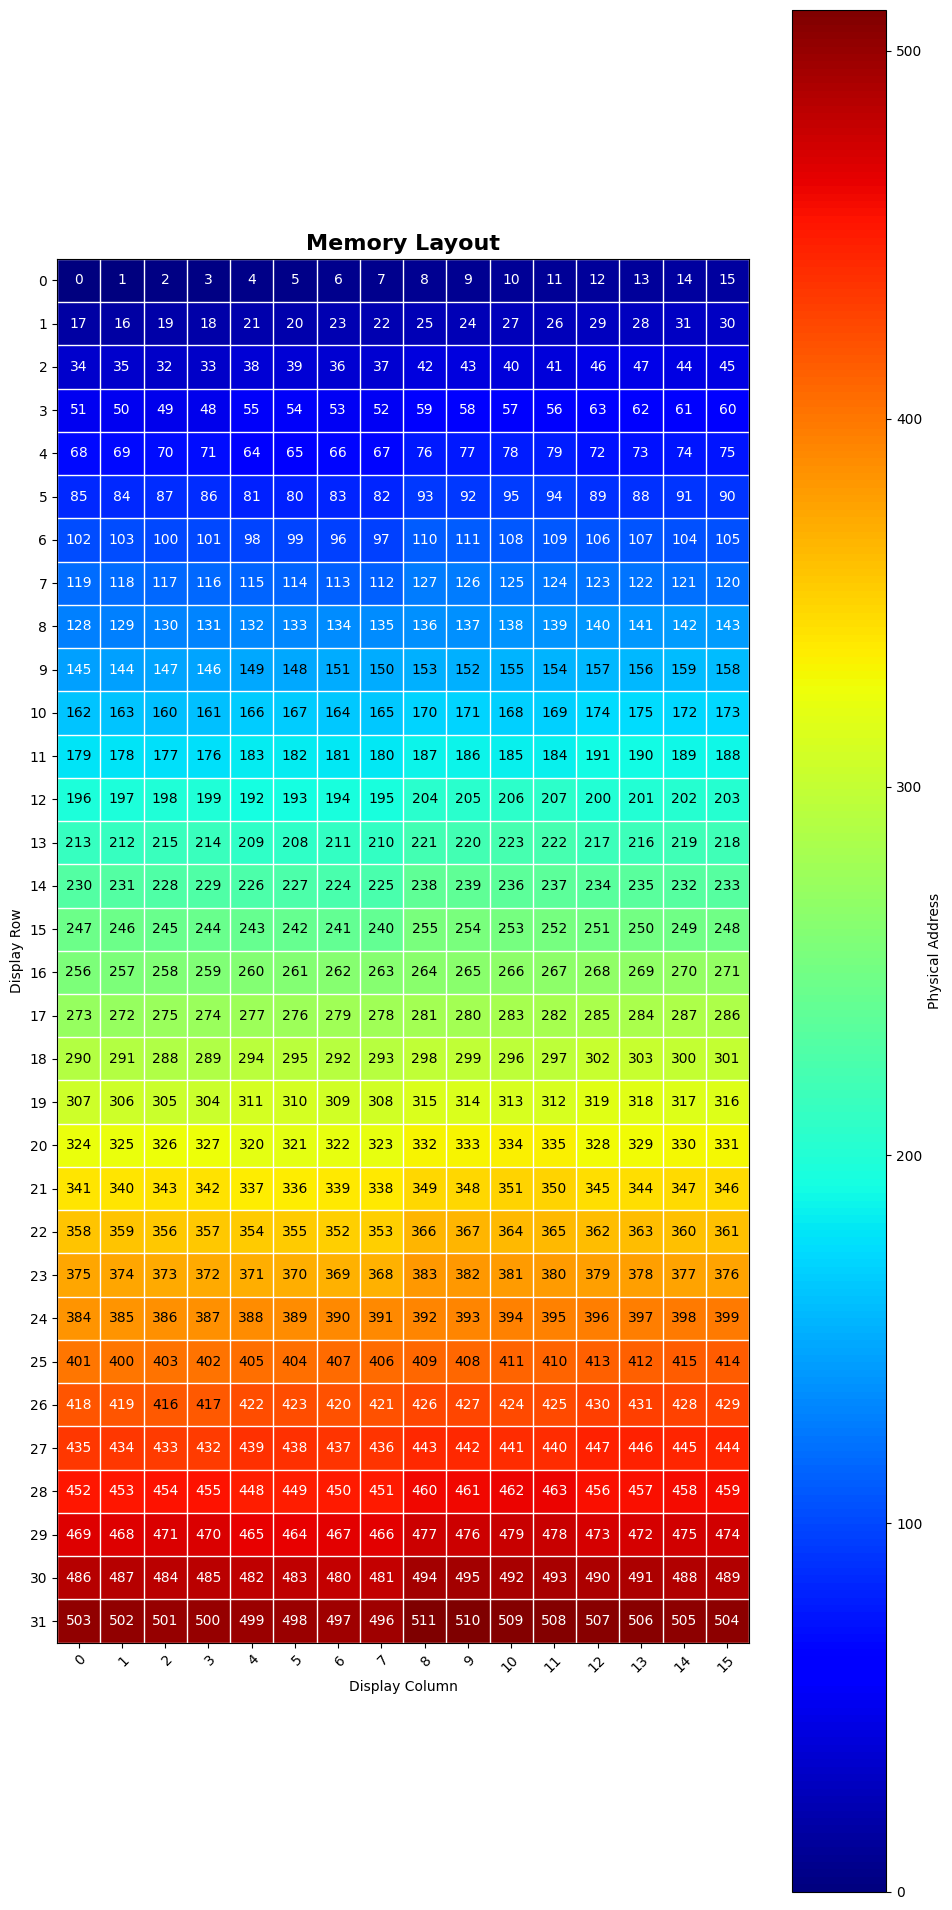

In [29]:
d.show()